In [199]:
from datetime import datetime
from gym.utils import seeding
from gym import spaces
from tqdm._tqdm_notebook import tqdm_notebook
import gym
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time

In [31]:
# preprocess training data
data_1 = pd.read_csv('./dlcompetition/train.csv')
date_col_name = list(data_1)[0]
print(date_col_name)
sample_time = data_1[date_col_name][0]
print(sample_time)
data_1["date"] = data_1[date_col_name].apply(lambda x : datetime.strptime(x, '%d/%m/%Y'))
data_1_date = data_1["date"]
print(len(data_1_date))
data_1 = data_1.drop([date_col_name], axis=1)

Unnamed: 0
01/01/2015
891


In [42]:
# test whether we could use extra data
data_2 = pd.read_csv('./dlcompetition/A.csv')
date_col_names = list(data_2)
data_2_date = data_2["datadate"].apply(lambda x : datetime.strptime(x, '%d/%m/%Y'))
print(len(data_2_date))

count = 0
data_2_date_set = set(data_2_date)
for i in data_1_date:
    if not (i in data_2_date_set):
        count += 1
print(count)

32


In [42]:
# save data after train test split
data_size = data_1.shape[0]
print("full data size: ", data_size)
train_size = int(data_size * 0.8)
train_data = data_1[:train_size]
test_data = data_1[train_size:]
print("train data shape: ", train_data.shape)
print("test data shape: ", test_data.shape)

train_data.to_pickle("./train_data.pkl")
test_data.to_pickle("./test_data.pkl")

full data size:  891
train data shape:  (712, 507)
test data shape:  (179, 507)


In [200]:
################
#  Start here  #
################

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras import optimizers
import logging
import pickle

train_data = pd.read_pickle("./train_data.pkl")
test_data = pd.read_pickle("./test_data.pkl")

In [234]:
params = {
    "batch_size": 20,  # 20<16<10, 25 was a bust
    "epochs": 200,
    "lr": 0.0010000,
    "time_steps": 30
}

iter_changes = "dropout_layers_0.5_0.5"

OUTPUT_PATH = "./outputs/lstm_best_1-12-19_16AM/"+iter_changes

TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]
stime = time.time()

def print_time(text, stime):
    seconds = (time.time()-stime)
    print(text, seconds//60,"minutes : ",np.round(seconds%60),"seconds")

In [235]:
def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    
    if len(mat.shape) == 1:
        dim_1 = 1
        x = np.zeros((dim_0, TIME_STEPS))
    else:
        dim_1 = mat.shape[1]
        x = np.zeros((dim_0, TIME_STEPS, dim_1))

    y = np.zeros((dim_0,))
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        if dim_1 == 1:
            y[i] = mat[TIME_STEPS+i]
        else:
            y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

def build_timeseries_mat(mat):
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))

    y = np.zeros((dim_0, dim_1))
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [236]:
# One model for all stocks
x_train = train_data.drop(["Cash", "date"], axis=1)
x_test = test_data.drop(["Cash", "date"], axis=1)

# check nan in training data
na_cols = x_train.isna().sum().to_numpy().nonzero()
na_sums = x_train.isna().sum()
print("checking if any null values are present\n", na_cols)

zero_cols = []
interpolate_cols = []
for i in na_cols[0]:
    col_name = x_train.columns[i]
    if na_sums[i] == x_train.shape[0]:
#         print(col_name, na_sums[i], x_test.isna().sum()[i])
        zero_cols.append(i)
    else:
        interpolate_cols.append(i)

# fill zero into columns with nan entries more than 1/4 of the total entries
for col in zero_cols:
    col_name = x_train.columns[col]
    x_train[col_name].values[:] = 0
    x_test[col_name].values[:] = 0

# fill the rest nan with column mean
for col in interpolate_cols:
    col_name = x_train.columns[col]
    x_train[col_name].values[:] = x_train[col_name].fillna(x_train[col_name].mean())
    x_test[col_name].values[:] = x_test[col_name].fillna(x_train[col_name].mean())

print("checking if any null values are present\n", x_train.isna().sum().to_numpy().nonzero())

# normalize
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x_train)
x_test = min_max_scaler.transform(x_test)

x_t, y_t = build_timeseries_mat(x_train)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)

x_temp, y_temp = build_timeseries_mat(x_test)
x_val, x_test = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

checking if any null values are present
 (array([ 32,  33,  50, 122, 126, 147, 154, 174, 194, 195, 200, 231, 246,
       270, 292, 297, 335, 353, 367, 369, 390, 392, 395, 441, 452, 486,
       490, 495], dtype=int64),)
checking if any null values are present
 (array([], dtype=int64),)



length of time-series i/o (682, 30, 505) (682, 505)



length of time-series i/o (149, 30, 505) (149, 505)


In [207]:
# One model per individual stock
# x_train = train_data['AAL ']
# x_t, y_t = build_timeseries(x_train, 0)
# x_t = trim_dataset(x_t, BATCH_SIZE)
# y_t = trim_dataset(y_t, BATCH_SIZE)

# x_t = np.reshape(x_t, (x_t.shape[0], x_t.shape[1], 1))

# x_test = test_data['A ']
# x_test = x_test.reset_index(drop=True)
# x_temp, y_temp = build_timeseries(x_test, 0)
# x_val, x_test = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
# y_val, y_test = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

In [237]:
x_val_t = trim_dataset(x_val, BATCH_SIZE)
# x_val_t = np.reshape(x_val_t, (x_val_t.shape[0], x_val_t.shape[1], 1))
val_data_t = (x_val_t, trim_dataset(y_val, BATCH_SIZE))

In [218]:
def create_model():
    lstm_model = Sequential()
    
    features = 1 if len(x_t.shape) == 2 else x_t.shape[2]
#     print("data_dim: ", features)

    # (batch_size, timesteps, data_dim)
    lstm_model.add(LSTM(128, batch_input_shape=(BATCH_SIZE, TIME_STEPS, features),
                        dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=False,
                        kernel_initializer='random_uniform'))
    lstm_model.add(Dropout(0.5))
#     lstm_model.add(LSTM(64, dropout=0.0))
#     lstm_model.add(Dropout(0.5))
    lstm_model.add(Dense(64,activation='relu'))
    lstm_model.add(Dropout(0.5))
    lstm_model.add(Dense(features,activation='sigmoid'))
    optimizer = optimizers.RMSprop(lr=params["lr"])
    # optimizer = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    print(lstm_model.summary())
    return lstm_model

In [238]:
model = None

is_update_model = True
if model is None or is_update_model:
    model = create_model()
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                       patience=40, min_delta=0.0001)
    
    mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH,
                          "best_model.h5"), monitor='val_loss', verbose=1,
                          save_best_only=True, save_weights_only=False, mode='min', period=1)

    # Not used here. But leaving it here as a reminder for future
#     r_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=30, 
#                                   verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
    csv_path = os.path.join(OUTPUT_PATH, 'training_log_' + time.ctime().replace(" ","_").replace(":", "_") + '.log')
    csv_logger = CSVLogger(csv_path, append=True)
    
    callbacks = [es, mcp, csv_logger]
    history = model.fit(x_t, y_t, epochs=params["epochs"], verbose=2, batch_size=BATCH_SIZE,
                        shuffle=False, validation_data=val_data_t, callbacks=callbacks)
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_42 (LSTM)               (20, 128)                 324608    
_________________________________________________________________
dropout_45 (Dropout)         (20, 128)                 0         
_________________________________________________________________
dense_54 (Dense)             (20, 64)                  8256      
_________________________________________________________________
dropout_46 (Dropout)         (20, 64)                  0         
_________________________________________________________________
dense_55 (Dense)             (20, 505)                 32825     
Total params: 365,689
Trainable params: 365,689
Non-trainable params: 0
_________________________________________________________________
None
Train on 680 samples, validate on 60 samples
Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.26188, saving model to ./out

In [223]:
x_test_t = trim_dataset(x_test, BATCH_SIZE)
# x_test_t = np.reshape(x_test_t, (x_test_t.shape[0], x_test_t.shape[1], 1))

y_pred = model.predict(x_test_t, batch_size=BATCH_SIZE)
# y_pred = y_pred.flatten()

y_test_t = trim_dataset(y_test, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
# print(y_pred[15])
# print(y_test_t[15])

Error is 0.17233163088882267 (60, 505) (60, 505)


In [224]:
# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[15][:10])
print(y_test_t_org[15][:10])

[152.1991   146.99384  110.179405 158.42355  132.24983  125.29541
 153.09755  149.0763   148.46529  155.9642  ]
[167.15121341 157.83698918 109.38879788 176.82       211.642
 131.3922648  230.54065243 199.87935065 192.50713968 210.11026588]


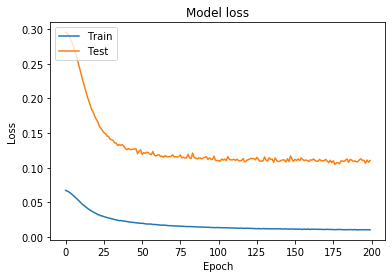

In [226]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()
plt.savefig(os.path.join(OUTPUT_PATH, 'train_vis_BS_'+str(BATCH_SIZE)+"_"+time.ctime().replace(" ","_").replace(":", "_")+'.png'))

In [225]:
# load the saved best model from above
saved_model = load_model(os.path.join(OUTPUT_PATH, 'best_model.h5')) # , "lstm_best_7-3-19_12AM",
print(saved_model)

y_pred = saved_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
# y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
# print(y_pred[0:15])
# print(y_test_t[0:15])
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[15][:10])
print(y_test_t_org[15][:10])

Error is 0.1705119168039326 (60, 505) (60, 505)
[152.91003 147.37125 110.59215 158.59422 131.7466  126.18728 153.3399
 149.10004 149.26688 156.48886]
[167.15121341 157.83698918 109.38879788 176.82       211.642
 131.3922648  230.54065243 199.87935065 192.50713968 210.11026588]


program completed  107.0 minutes :  46.0 seconds


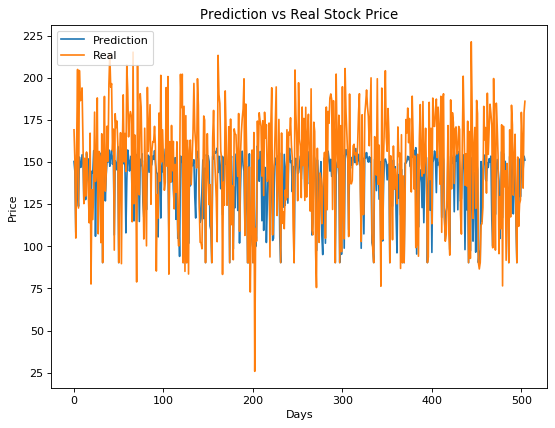

In [158]:
# Visualize the prediction
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(y_pred_org[0])
plt.plot(y_test_t_org[0])
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
# plt.show()
plt.savefig(os.path.join(OUTPUT_PATH, 'pred_vs_real_BS'+str(BATCH_SIZE)+"_"+time.ctime().replace(" ","_").replace(":", "_")+'.png'))
print_time("program completed ", stime)